# business Problem

#### Objetivo do Problema
    -- Previsão do primeiro destino que um novo usuario irá escolher.

#### Porque?
**Qual tipo de modelo de negócio do AirBNB?**
    
    -- MarketPlace (Conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação).

##### Oferta (Pessoas oferecendo acomodação)

    -- Tamanho do portfolio
    -- Diversidade/densidade de portfolio
    -- Preço medio

##### Demanda (Pessoas procurando acomodação)

    -- Numero de usuarios
    -- LTV (Lifitime Value)
    -- CAC (Client Acquisition Cost)

**Cross Revenue** (FEE * Numero Cliente) - CAC

#### Proposta da Solução

    -- Modelo de predição do primeiro destino de um novo usuario.

##### Tipos de formatos para entrega do projeto.
    -- Predições salva em tabela do banco de dados.
    -- API: Input: Usuario e suas caracteristicas / Output: Usuario e suas caracteristicas com as Predições do destino.

# Ciclo05: Balanced Dataset

# 00 - Imports

In [1]:
import pandas as pd
import random
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt

from keras import models as ml
from keras import layers as l

#Balanced dataset
from imblearn import under_sampling as us  #Random Undersampling
from imblearn import over_sampling as over #Random Oversampling
from imblearn import combine as c          #SMOTE + TOMELINK

import warnings
import pickle

warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML(""))

2022-12-26 18:46:59.320310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-26 18:46:59.431678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-26 18:46:59.431691: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-26 18:46:59.450404: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-26 18:47:00.039676: W tensorflow/stream_executor/platform/de

## Functions

In [2]:
def drescriptive_statistical (df):

    num_atributes = df.copy()
    #Central Tendency - mean - median
    ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

    #Dispersion - STD, min, max, range, sken, Kurtosis
    d1 = pd.DataFrame(num_atributes.apply(np.std)).T
    d2 = pd.DataFrame(num_atributes.apply(min)).T
    d3 = pd.DataFrame(num_atributes.apply(max)).T
    d4 = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min() )).T
    d5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew() )).T
    d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis() )).T

    #Concatenate

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    jupyter_settings()


#Function Calculates cramer V
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - ( k - 1 ) * ( r - 1) / (n - 1))
    kcorr = k - (k - 1) **2/(n - 1) 
    rcorr = r - (r - 1) **2/(n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr -1, rcorr -1) ) )

## Paths

In [3]:
path_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/data/'
path_model = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/models/'
path_transformation = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/transformation_data/'

## Loading Data

|Feature Name| Information|
|----------------|:---------------:|
|id:                         |ID do Usuario
|date_account_created:       |Data da Criação da Conta
|timestamp_first_active:     |Data do primeira acesso, note que pode ser anterior à data de criação da conta ou à data da primeira reserva porque um utilizador pode pesquisar antes de se inscrever
|date_first_booking:         |data da primeira reserva
|gender                      |Sexo
|age                         |Idade 
|signup_method               |Metodo de inscrição
|signup_flow:                |fluxo de inscrição: a página de onde um utilizador veio para se inscrever
|language:                   |Preferencia linguistica internacional
|affiliate_channel:          |canal afiliado: que tipo de marketing pago
|affiliate_provider:         |fornecedor afiliado: onde o marketing é, por exemplo, google, craigslist, outro
|first_affiliate_tracked:    |primeira afiliação rastreada: qual foi o primeiro marketing com que o utilizador interagiu antes da inscrição
|signup_app                  |Aplicativo de inscrição
|first_device_type           |Primeiro tipo de dispositivo
|first_browser               |Primeiro nagevagor
|country_destination:        |Destino do pai:Variavel alvo que deve prever


In [4]:
data1 = pd.read_csv(path_data+ 'ciclo004_feature_Engineering.csv')

data1.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,date_first_booking_year,date_account_created_month,timestamp_first_active_month,date_first_booking_month,date_account_created_week,timestamp_first_active_week,date_first_booking_week,date_account_created_day,timestamp_first_active_day,date_first_booking_day
0,gxn3p5htnn,-unknown-,49,facebook,0,en,direct,direct,untracked,Web,...,2015,6,9,6,0,1,0,28,3,29
1,820tgsjxq7,MALE,38,facebook,0,en,seo,google,untracked,Web,...,2015,5,9,6,2,1,0,25,5,29
2,4ft3gnwmtx,FEMALE,56,basic,3,en,direct,direct,untracked,Web,...,2010,9,9,8,1,6,0,28,6,2
3,bjjt8pjhuk,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,...,2012,12,9,9,0,2,5,5,10,8
4,87mebub9p4,-unknown-,41,basic,0,en,direct,direct,untracked,Web,...,2010,9,9,2,1,4,3,14,12,18


In [5]:
data1['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

## 6.1 Encoder Categorical Variable

In [6]:
ohe = pp.OneHotEncoder()

#Excluir Variavel resposta

#Numerical
col_num = data1.select_dtypes( include= ['int64', 'float64']).columns.tolist()

#Categorical
col_cat = data1.select_dtypes( exclude= ['int64', 'float64', 'datetime64[ns]']).drop( ['id','country_destination'], axis=1).columns.tolist()

#Encoding
df_dumy = pd.DataFrame(ohe.fit_transform(data1[ col_cat ]).toarray(), index=data1.index)

#Join numerical and categorical
data2 = pd.concat([data1[ col_num], df_dumy], axis=1)

# 7.0 Balanced Dataset

## 6.1 Random Undersampling

##### sampling_strategy

- 'majority': resample only the majority class; Mostra apenas a classe majoritária

- 'not minority': resample all classes but the minority class; Mostra a todas as classes exceto a minoritaria

- 'not majority': resample all classes but the majority class; Mostra a todas as classes exceto a majoritária

- 'all': resample all classes; Mostra a todas as classes

- 'auto': equivalent to 'not minority'.

In [7]:
data_balanced = data1

In [8]:
#Define sampler
undersampling = us.RandomUnderSampler( sampling_strategy='auto', random_state=32) #Definir qual estrategia vai usar.

#Apply sampler
X_under, y_under = undersampling.fit_resample(data2, data_balanced['country_destination'])


In [9]:
data_balanced['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [10]:
y_under.value_counts()

AU       213
CA       213
DE       213
ES       213
FR       213
GB       213
IT       213
NDF      213
NL       213
PT       213
US       213
other    213
Name: country_destination, dtype: int64

## 6.2 Random Oversampling

In [11]:
#Define sampler
oversampling = over.RandomOverSampler( sampling_strategy='auto', random_state=32) #Definir qual estrategia vai usar.

#Apply sampler
X_over, y_over = oversampling.fit_resample(data2, data_balanced['country_destination'])


In [12]:
data_balanced['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [13]:
y_over.value_counts()

NDF      119810
US       119810
other    119810
CA       119810
FR       119810
ES       119810
GB       119810
IT       119810
PT       119810
NL       119810
DE       119810
AU       119810
Name: country_destination, dtype: int64

## 6.3 SMOTE + TOMELINK

In [14]:
len(data1['country_destination'])

206593

In [15]:
60800 / 4881

12.456463839377177

In [16]:
#Podemos criar um balanceamente entre as classes manualmente para que elas não fiquem todas com o mesmo valor, pois não precisamos ter exatamente todas as classes com o mesmo valor e dessa forma os dados ficam
#mais reais do que temos atualmente. Tentando evitar o overfitting do modelo.

ratio_balanced = {'NDF':       119810,
                  'US':   2 * 60800,
                  'other': 11 * 9935,
                  'FR':    24 * 4881,
                  'IT':    40 * 2776,
                  'GB':    45 * 2285,
                  'ES':    45 * 2203,
                  'CA':    71 * 1385,
                  'DE':    95 * 1033,
                  'NL':   130 * 746,
                  'AU':   180 * 526,
                  'PT':   440 * 213}

ratio_balanced

{'NDF': 119810,
 'US': 121600,
 'other': 109285,
 'FR': 117144,
 'IT': 111040,
 'GB': 102825,
 'ES': 99135,
 'CA': 98335,
 'DE': 98135,
 'NL': 96980,
 'AU': 94680,
 'PT': 93720}

In [17]:
smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1) #No lugar do Auto, colocar o Ratio_balanced e testar a performance

#Apply sampler
X_smt, y_smt = smt.fit_resample( data2, data_balanced['country_destination'])

In [18]:
#Encodar os dados de volta, pois foi preciso encodar para utilizar o SMOTE.

#numerical data
df_aux1 = X_smt[col_num]

#Categorical data
df_aux2 = X_smt.drop(col_num, axis=1)

#Encodando
df_aux3 = pd.DataFrame(ohe.inverse_transform( df_aux2), columns= col_cat, index=  df_aux2.index)

#Join numerical categorical
df_final = pd.concat( [df_aux3, df_aux1 ], axis= 1)
df_final['country_destination'] = y_smt

In [29]:
#Df final com o balanceamento
df_final.to_csv(path_data+'ciclo005_balanced_dataset.csv', index=False)

In [30]:
df_final['country_destination'].value_counts()

US       121057
NDF      119810
FR       116846
IT       110848
other    108793
GB       102656
ES        98982
CA        98204
DE        98051
NL        96923
AU        94631
PT        93716
Name: country_destination, dtype: int64

# 8.0 Feature Selection

In [31]:
data = pd.read_csv(path_data+'ciclo005_balanced_dataset.csv')

data.head()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,age,...,date_account_created_month,timestamp_first_active_month,date_first_booking_month,date_account_created_week,timestamp_first_active_week,date_first_booking_week,date_account_created_day,timestamp_first_active_day,date_first_booking_day,country_destination
0,-unknown-,facebook,en,direct,direct,untracked,Web,Mac Desktop,Chrome,49,...,6,9,6,0,1,0,28,3,29,NDF
1,MALE,facebook,en,seo,google,untracked,Web,Mac Desktop,Chrome,38,...,5,9,6,2,1,0,25,5,29,NDF
2,FEMALE,basic,en,direct,direct,untracked,Web,Windows Desktop,IE,56,...,9,9,8,1,6,0,28,6,2,US
3,FEMALE,facebook,en,direct,direct,untracked,Web,Mac Desktop,Firefox,42,...,12,9,9,0,2,5,5,10,8,other
4,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,41,...,9,9,2,1,4,3,14,12,18,US


In [32]:
#GetDummies values (Para uso da Rede Neural precisamos preparar os dados dessa forma)

data_preparation_dummies = pd.get_dummies(data.drop(['country_destination'], axis=1))

# Jooin id And country destination
data_preparation_final = pd.concat( [data[['country_destination']], data_preparation_dummies], axis=1)

In [33]:
X = data_preparation_final.drop('country_destination', axis=1)
y = data_preparation_final['country_destination'].copy()

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=32)

In [35]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1)).toarray()

# 9.0 Machine Learning Model

### Baseline Model

In [36]:
country_destination_list = data_preparation_final['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_val.shape[0]
country_destination_weights = data_preparation_final['country_destination'].value_counts( normalize=True).sort_index().tolist()

#Modelo Aleatório
yhat_random = random.choices( population=country_destination_list, k=k_num, weights=country_destination_weights)

Accuracy: 0.08451274077364897
Balanced Accuracy: 0.08380897640351921
Kappa Score: 0.0005000968514703441


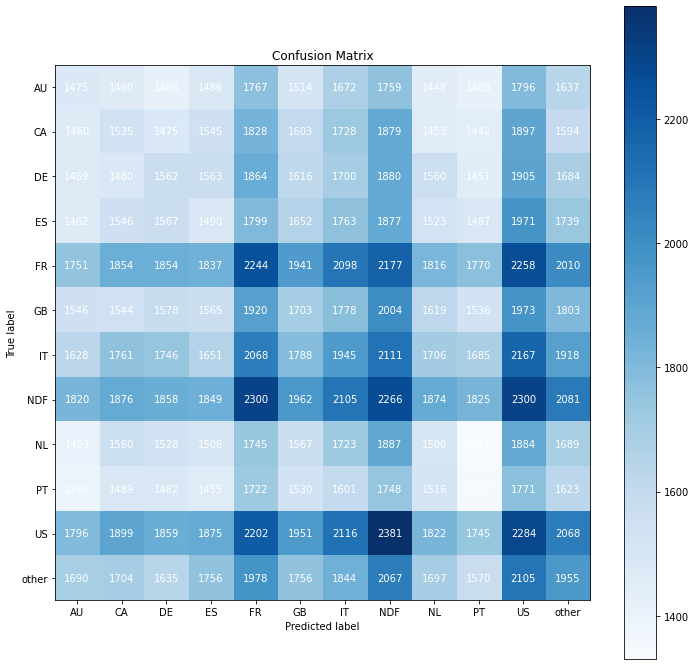

In [37]:
#Accuracy
acc_random = m.accuracy_score(y_val, yhat_random)
print('Accuracy: {}'.format(acc_random))

#Confusion Matrix
mt.plot_confusion_matrix( y_val, yhat_random, normalize= False, figsize=(12,12))

#Balanced Accuracy
balanced_accuracy_random = m.balanced_accuracy_score(y_val, yhat_random )
print('Balanced Accuracy: {}'.format(balanced_accuracy_random))

#Kappa Metrics
kappa_score_random = m.cohen_kappa_score(y_val, yhat_random)
print('Kappa Score: {}'.format(kappa_score_random))

#Objetivo é aumentar o Balanced Accuracy para uns 85% (Acuracia para apresentar ao time de negocio
#Kappa Score uns 75% (Nivel de concordancia entre as classes).

#print(m.classification_report(y_val_nn, yhat_nn))

### Neural Network MLP

In [42]:
model = pickle.load(open(path_model+'ciclo005_model_NLP.pkl', 'rb'))

#Prediction
pred_nn = model.predict(X_val)

#Invert prediction
#yhat_nn = ohe.inverse_transform(pred_nn)

#Prediction prepare
#y_val_nn = y_val.to_numpy()
#yhat_nn = yhat_nn.reshape(1, -1)[0]

2022-12-26 19:38:45.635967: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 296474304 exceeds 10% of free system memory.


ValueError: in user code:

    File "/home/wellington/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/home/wellington/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/wellington/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/home/wellington/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/home/wellington/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/wellington/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 39), found shape=(None, 147)


Accuracy: 0.19084187478183606
Balanced Accuracy: 0.16665973863452888
Kappa Score: 0.10566975266472478


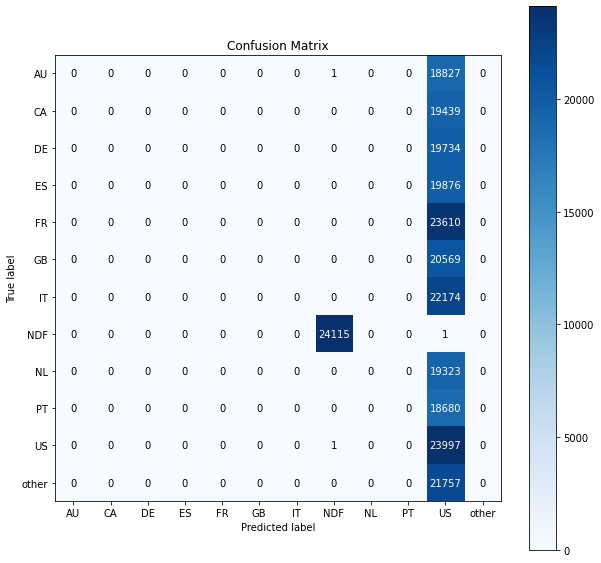

In [42]:
#Accuracy
acc_nn = m.accuracy_score(y_val_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#Confusion Matrix
mt.plot_confusion_matrix( y_val_nn, yhat_nn, normalize= False, figsize=(10,10))

#Balanced Accuracy
balanced_accuracy = m.balanced_accuracy_score(y_val_nn, yhat_nn )
print('Balanced Accuracy: {}'.format(balanced_accuracy))

#Kappa Metrics
kappa_score = m.cohen_kappa_score(y_val_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_score))

#Objetivo é aumentar o Balanced Accuracy para uns 85% (Acuracia para apresentar ao time de negocio
#Kappa Score uns 75% (Nivel de concordancia entre as classes).

#print(m.classification_report(y_val_nn, yhat_nn))